In [13]:
import cv2
from tqdm import tqdm      
from random import shuffle
from zipfile import ZipFile
import glob
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

In [5]:
def get_path(directory):
    path = []
    for files in os.listdir(directory):
        path.append(files)
    return path

train_path = get_path('train')
test_path = get_path('test')

<a id = 'sec3'></a>
# Visualizing Data

In [6]:
def label_img(img):
    category = img.split('.')[-3]
    if category == 'cat': 
        return [1,0]
    elif category == 'dog': 
        return [0,1]

def process_data(img_data, data_dir, isTrain=True):
    data_df = []
    for img in tqdm(img_data):
        #print(img)
        path = os.path.join(data_dir,img)     
        if(isTrain):
            label = label_img(img)            #Calling label_img to assign labels to image present in training directory
        else:
            label = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img, (224,224))
        data_df.append([np.array(img),np.array(label)]) #append image and labels as numpy array in data_df list
    shuffle(data_df)
    return data_df

In [7]:
#We will plot the images of dogs and cats and display the assigned label above image
def show_images(data, isTest=False):
    f, ax = plt.subplots(nrows = 5, ncols = 5, figsize = (15,15))
    for i,data in enumerate(data[:25]):              #enumerate helps in keeping track of count of iterations
        img_num = data[1]
        img_data = data[0]
        label = np.argmax(img_num)                    #to get maximum indices of an array
        if label  == 1: 
            str_label='Dog'
        elif label == 0: 
            str_label='Cat'
        if(isTest):
            str_label="None"
        ax[i//5, i%5].imshow(img_data)
        ax[i//5, i%5].axis('off')                 #removing axis for better look
        ax[i//5, i%5].set_title("Label: {}".format(str_label))
    plt.show()

100%|██████████| 25000/25000 [00:59<00:00, 421.95it/s]


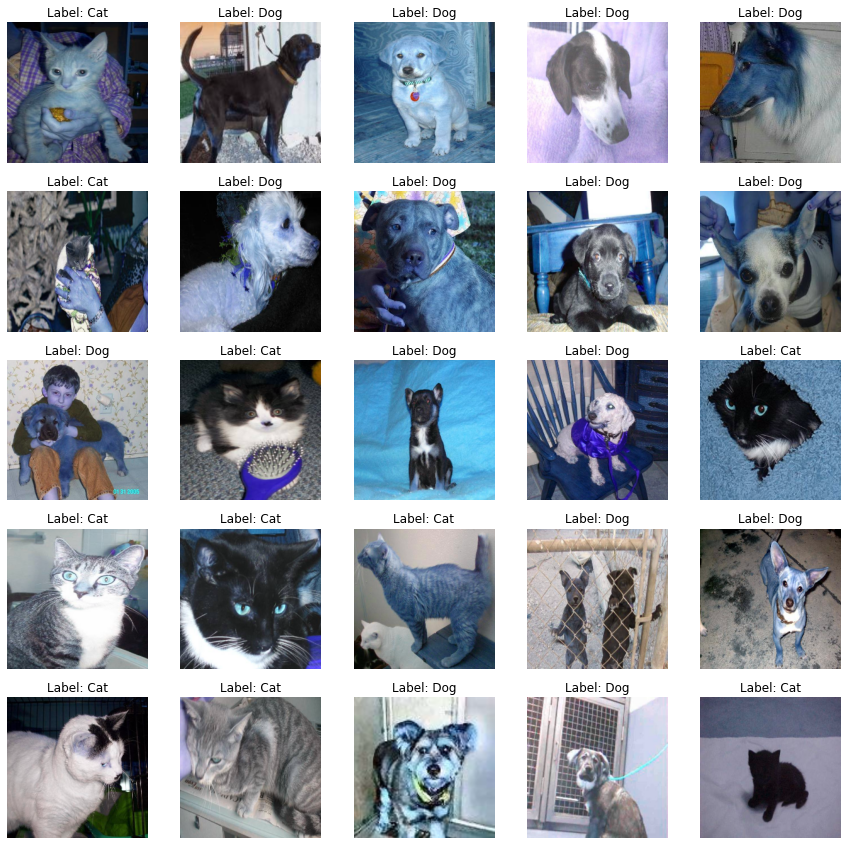

In [14]:
train = process_data(train_path, './train/')
show_images(train)

100%|██████████| 12500/12500 [00:29<00:00, 429.89it/s]


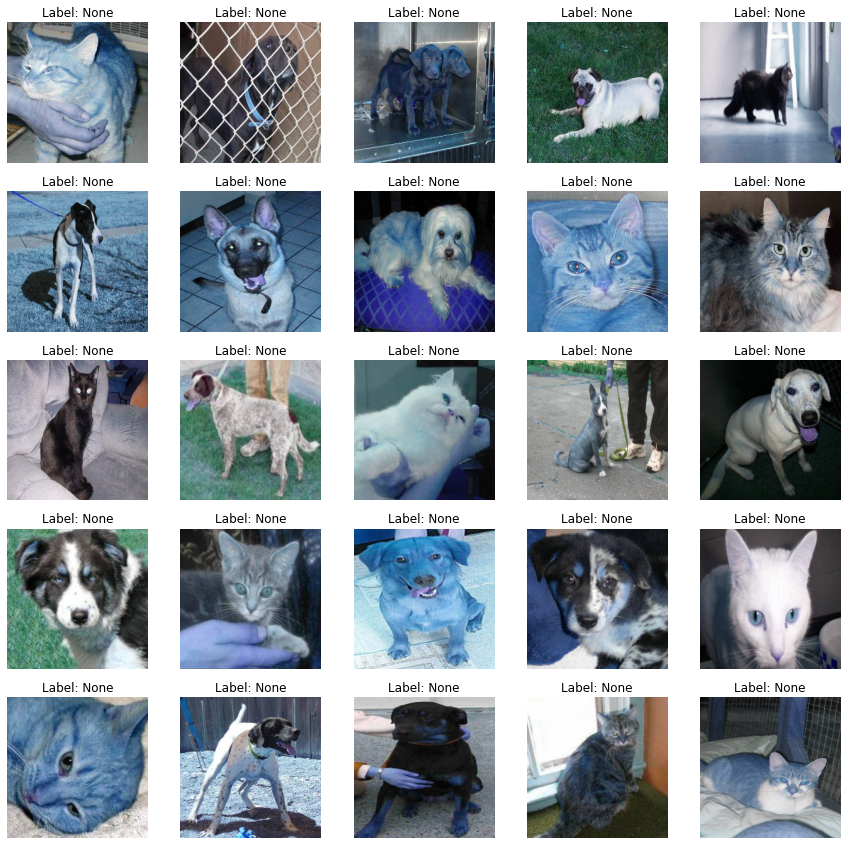

In [15]:
test = process_data(test_path, './test/', False)
show_images(test,True)

<a id = 'subsec11'></a>
<span style="color:green;font-size:20px"> Convert data into dataframe </span>

In our data formatting, we will generate the respective labels for dogs (1) and cats (0) for our training data. File path will also be collected as a column for our dataframe so that it can be used to load and train our images.  

file.split('.')[0] means -
* the particular filename is a String separated by dots.
* line.split(".")[0] returns the 1st item of the array. (the actual file looks like "cat.134.jpg")

In [16]:
#We will use below function to label data
def get_label(directory):
    label = []
    for file in os.listdir(directory):
        if (file.split('.')[0] == 'dog'):
            label.append(str(1))
        elif (file.split('.')[0] == 'cat'):
            label.append(str(0))
    return label

label = get_label('train')
df = pd.DataFrame({'filename': train_path, 'label': label})
df.head()

filename label
0   dog.8011.jpg     1
1   cat.5077.jpg     0
2   dog.7322.jpg     1
3   cat.2718.jpg     0
4  cat.10151.jpg     0

In [17]:
#split data into train and valid set
train_df, valid_df = train_test_split(df, test_size = 0.2, stratify = df['label'], random_state = 777)
print(train_df.shape)
print(valid_df.shape)

(20000, 2)
(5000, 2)


In [18]:
#train, vaild 分開處理
train_datagen = ImageDataGenerator(rotation_range = 10, zoom_range = 0.1, horizontal_flip = True, fill_mode = 'nearest', 
                                   width_shift_range = 0.1, height_shift_range = 0.1, preprocessing_function = preprocess_input)

#flow_from_dataframe() to generate batches
#filename as x_column and label as y_column
train_gen = train_datagen.flow_from_dataframe(train_df, directory = 'train', x_col = 'filename', y_col = 'label', target_size = (224,224),
                                              batch_size = 128, class_mode='binary')

valid_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)

valid_gen = valid_datagen.flow_from_dataframe(valid_df, directory = 'train', x_col = 'filename', y_col = 'label', target_size = (224,224),
                                              batch_size = 128, class_mode='binary')

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


<a id = 'sec5'></a>
# Model

In [20]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context
model = Sequential()
model.add(ResNet50(include_top = False, pooling = 'max', weights = 'imagenet'))
model.add(Dense(1, activation = 'sigmoid'))
model.layers[0].trainable = False 

94765736/94765736 [==============================] - 17s 0us/step


In [21]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense (Dense)               (None, 1)                 2049      
                                                                 
Total params: 23,589,761
Trainable params: 2,049
Non-trainable params: 23,587,712
_________________________________________________________________


In [22]:
model.compile(optimizer = 'adam', metrics = ['accuracy'], loss = 'binary_crossentropy')

In [23]:
checkpointer = ModelCheckpoint(filepath = 'dogcat.weights.best.hdf5', save_best_only = True, save_weights_only = True)

In [24]:
model.fit_generator(train_gen, epochs = 10, validation_data = valid_gen, callbacks = [checkpointer])

Epoch 1/10
157/157 [==============================] - 1242s 8s/step - loss: 0.2369 - accuracy: 0.9459 - val_loss: 0.1043 - val_accuracy: 0.9786
Epoch 2/10
157/157 [==============================] - 1260s 8s/step - loss: 0.0993 - accuracy: 0.9781 - val_loss: 0.0864 - val_accuracy: 0.9818
Epoch 3/10
157/157 [==============================] - 1264s 8s/step - loss: 0.0825 - accuracy: 0.9821 - val_loss: 0.0797 - val_accuracy: 0.9830
Epoch 4/10
157/157 [==============================] - 1306s 8s/step - loss: 0.0677 - accuracy: 0.9847 - val_loss: 0.0769 - val_accuracy: 0.9828
Epoch 5/10
157/157 [==============================] - 1308s 8s/step - loss: 0.0786 - accuracy: 0.9832 - val_loss: 0.0771 - val_accuracy: 0.9856
Epoch 6/10
157/157 [==============================] - 1355s 9s/step - loss: 0.0652 - accuracy: 0.9861 - val_loss: 0.0699 - val_accuracy: 0.9850
Epoch 7/10
157/157 [==============================] - 1416s 9s/step - loss: 0.0628 - accuracy: 0.9858 - val_loss: 0.0919 - val_accuracy:

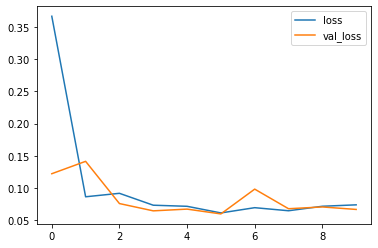

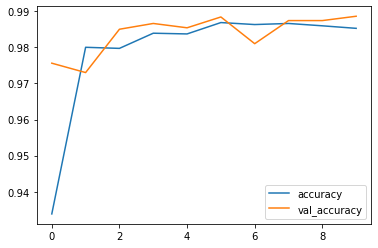

In [17]:
loss = pd.DataFrame(model.history.history)
loss[['loss', 'val_loss']].plot()
loss[['accuracy', 'val_accuracy']].plot()

In [26]:
#load the best weights saved using checkpointer
model.load_weights('dogcat.weights.best.hdf5')

In [27]:
test_df = pd.DataFrame({'filename': test_path})    #test_path from function get_path

In [35]:
test_sample = test_df.sample(n = 20, random_state = 777)   
label_pred = []                         
for path in test_sample['filename'].to_numpy():
    full_path = './test/'+path
    x = load_img(full_path, target_size=(224,224))
    img_array = img_to_array(x)
    img_array = np.expand_dims(img_array, axis=0)
    
    pred =  model.predict(img_array)    
    pred = 'Dog' if float(pred) > 0.5 else 'Cat'
    label_pred.append(pred)

1/1 [==============================] - 0s 102ms/step


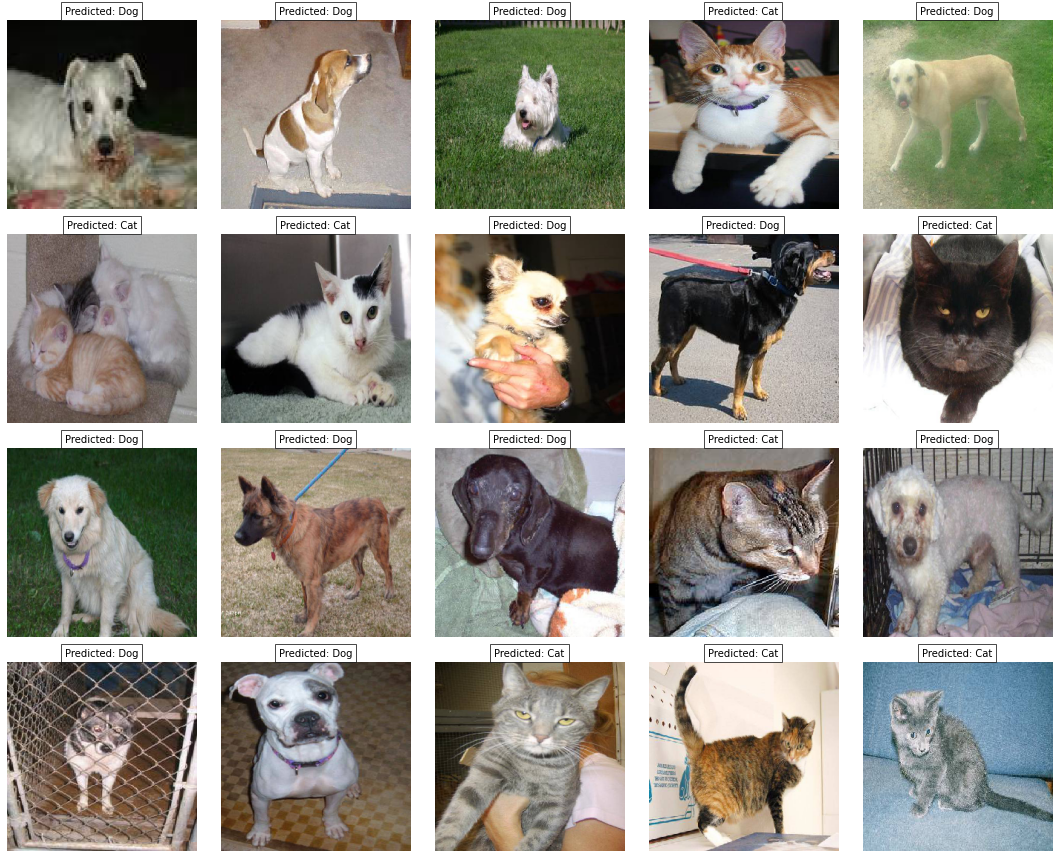

In [37]:
test_array = test_sample['filename'].to_numpy()            # convert dataframe to numpy array 

plt.figure(figsize=(15, 15))
for i in range(0, 20):
    plt.subplot(5, 5, i+1)
    img = test_array[i]
    path = './test/' + img
    image = load_img(path, target_size=(256,256))
    
    plt.title('Predicted: {}'.format(label_pred[i]), color='black',fontsize= 10, bbox=dict(facecolor='white', alpha=0.7))
    plt.imshow(image)
    plt.axis('off')

plt.tight_layout()

In [38]:
#Generate mini batches of test data
test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_gen = test_datagen.flow_from_dataframe(test_df, directory = './test/', batch_size = 64, x_col = 'filename', y_col = None, class_mode = None, shuffle = False, img_size = (224, 224))

Found 12500 validated image filenames.


In [39]:
prediction = model.predict_generator(test_gen)
#use clip to set the minimum and maximum
prediction = prediction.clip(min = 0.005, max = 0.995)     

In [42]:
submission_df = pd.read_csv('sample_submission.csv')

for i, fname in enumerate(test_path):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    submission_df.at[index-1, 'label'] = prediction[i]
submission_df.to_csv('Cats&DogsSubmission.csv', index=False)

In [43]:
submission_df.head()

id  label
0   1  0.995
1   2  0.995
2   3  0.995
3   4  0.995
4   5  0.005